In [23]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from tqdm import tqdm

In [32]:
Ms = 0.5*u.solMass

rmin = 1.0*u.au
rmax = 40.0*u.au
rmed = 10*u.au
deltar = 0.2*u.au


Ncells = 2000
ris = np.linspace(rmin, rmax, Ncells+1)
r = 0.5*(ris[1:] + ris[:-1])

alpha = 1e-2
h0 = 0.040613
flaring = 0.25
# h0 = 0.05
flaring = 0.0

sigma0 = 20*u.g/u.cm**2

particle_density = 2.65*u.g/u.cm**3
particle_size = 1e-5*u.cm

h = h0*r.to_value("au")**flaring

vK = np.sqrt(const.G*Ms/r)
OmegaK = vK/r
H = h*r
cs = h*vK

sigmag = sigma0 * r.to_value("au")**-1
rhog = sigmag / (np.sqrt(2*np.pi)*H)

tstop = particle_size*particle_density/(rhog*cs)
St = tstop * OmegaK

# Youdin & Lithwick 2007 Eq. 37
Sc = (1 + St**2)**2  / (1 + 4*St**2)

Dg = alpha*cs*H
Dd = Dg/Sc

Text(0, 0.5, 'Dd')

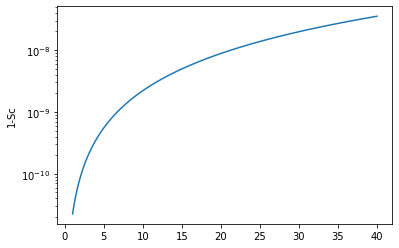

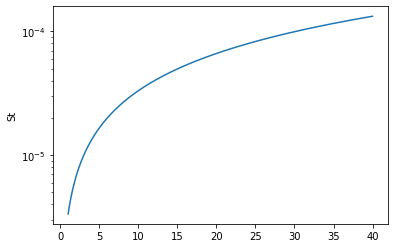

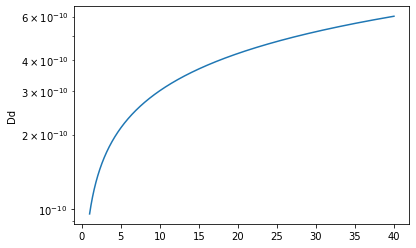

In [25]:
fig, ax = plt.subplots()
ax.plot(r, 1-Sc)
ax.set_yscale("log")
ax.set_ylabel("1-Sc")

fig, ax = plt.subplots()
ax.plot(r, St)
ax.set_yscale("log")
ax.set_ylabel("St")

fig, ax = plt.subplots()
ax.plot(r, Dd)
ax.set_yscale("log")
ax.set_ylabel("Dd")

Radial advection-diffusion equation according to Charnoz et al. 2011 Eq. (28)

$$\frac{dC}{dt} = \frac{1}{\rho_g r} \frac{\partial}{\partial r} ( -r V_r \rho_g C + r \rho_g D_d \frac{\partial C}{\partial r} )$$

with the dust concentration 

$C = \frac{\rho_d}{\rho_g}$.

$V_r$ is the gas radial velocity which is taken to be zero.

Then the equation to solves becomes the diffusion equation
$$\frac{dC}{dt} = \frac{1}{\rho_g r} \frac{\partial}{\partial r} (r \rho_g D_d \frac{\partial C}{\partial r})$$

In [26]:
def rhs(C):
    dCdr = np.gradient(C, r)
    X = r*rhog*Dd*dCdr
    dXdr = np.gradient(X, r)
    return dXdr / (r*rhog)
    

100%|██████████| 100/100 [00:00<00:00, 1313.75it/s]


(9.99, 10.01)

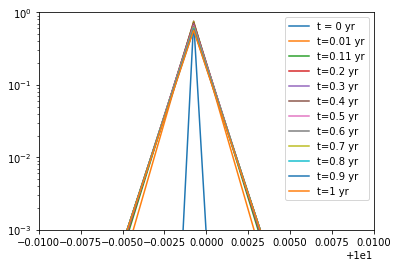

In [31]:
C = np.exp(- 0.5*(r.to_value("au") - 10)**2/(0.02**2))

t = 0*u.yr
dt = 0.01*u.yr
tfinal = 1*u.yr

t_save = 0.01*u.yr
N_save = int((tfinal / t_save).decompose()) + 1
times_save = np.linspace(0, tfinal, N_save)
saves = np.zeros((len(times_save), Ncells))


fig, ax = plt.subplots()

ax.plot(r, C, label = "t = 0 yr")

nplot = 0

saves[0] = C


for n in tqdm(range(N_save-1)):
    while t < times_save[n+1]:
        
        dCdt = rhs(C).decompose()
        C += (dt*dCdt).decompose().value
        t += dt
        
        if t > nplot*tfinal/10:
            ax.plot(r, C, label = f"t={t:.3g}")
            nplot += 1
    
    saves[n+1] = C

ax.legend()
ax.set_yscale("log")
ax.set_ylim(bottom=1e-3, top=1)

In [28]:
sigmads = np.zeros_like(saves)
for n, C in enumerate(saves):
    rhod = C*rhog
    sigmads[n] = rhod*(np.sqrt(2*np.pi)*H)

np.save("../analytical_data/analytic_profiles", sigmads)
np.save("../analytical_data/analytic_times", times_save.to_value("yr"))
np.save("../analytical_data/analytic_radii", r.to_value("au"))

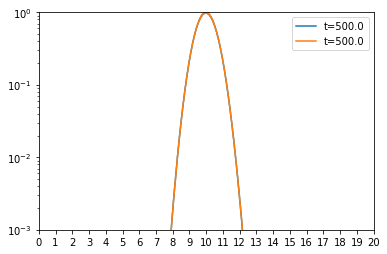

In [12]:
fig, ax = plt.subplots()

times = times_save.to_value("yr")

tplot = 2500
n = np.argmin(np.abs(times - tplot))
X = r
rhod = saves[n]
sigmad = rhod/(np.sqrt(2*np.pi)*H)
Y = sigmad / np.max(sigmad)
ax.plot(X, Y, label = f"t={times[n]}")

tplot = 5000
n = np.argmin(np.abs(times - tplot))
rhod = saves[n]
sigmad = rhod/(np.sqrt(2*np.pi)*H)
Y = sigmad / np.max(sigmad)
ax.plot(X, Y, label = f"t={times[n]}")

ax.set_yscale("log")
ax.set_ylim(bottom=1e-3,top=1)
ax.legend(loc="best")
ax.set_xlim(left=0, right=20)

ax.set_xticks(range(0,21));

Text(0, 0.5, 'rhog')

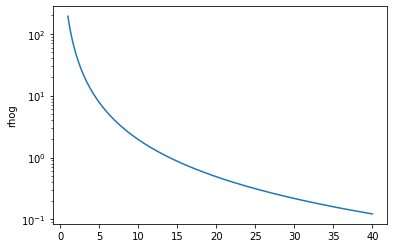

In [20]:
fig, ax = plt.subplots()
ax.plot(r, rhog)
ax.set_yscale("log")
ax.set_ylabel("rhog")

In [22]:
ls = np.load("../analytical_data/analytic_profiles.npy")
lt = np.load("../analytical_data/analytic_times.npy")
lr = np.load("../analytical_data/analytic_radii.npy")

(0.0, 20.0)

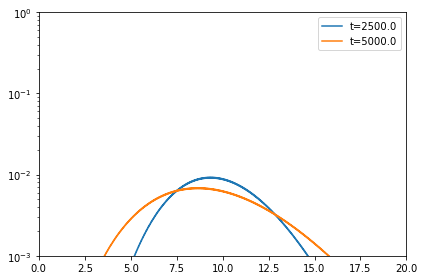

In [84]:
fig, ax = plt.subplots()

tplot = 2500
n = np.argmin(np.abs(lt - tplot))
ax.plot(rcs, ls[n], label = f"t={lt[n]}")

tplot = 5000
n = np.argmin(np.abs(lt - tplot))
ax.plot(rcs, ls[n], label = f"t={lt[n]}")

ax.set_yscale("log")
ax.set_ylim(bottom=1e-3,top=1)
ax.legend(loc="best")
ax.set_xlim(left=0, right=20)

In [86]:
lr

array([ 1.00975,  1.02925,  1.04875, ..., 39.95125, 39.97075, 39.99025])